<a href="https://colab.research.google.com/github/plaban1981/OpenAI_CLIP/blob/main/image_to_prompt_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-2e479ee9-b6ca-f346-c835-653a943caf81)


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


https://www.youtube.com/watch?v=2FZ6Tc7Yc_U&list=PLc9_vneTcTGXdjoCD0b_-2x3-HqsvxCZH&index=42

https://pharmapsychotic.com/tools.html

https://huggingface.co/spaces/pharma/CLIP-Interrogator/blob/main/app.py

https://www.youtube.com/watch?v=2EV5SZ1Klro

In [ ]:
os.mkdir("/content/drive/MyDrive/STABLE_DIFFUSION/image_to_prompt/output")

In [ ]:
for files in os.listdir("/content/output"):
  shutil.copy(os.path.join("/content/output",files),"/content/drive/MyDrive/STABLE_DIFFUSION/image_to_prompt/output")

In [ ]:
import os, subprocess

def setup():
    install_cmds = [
        ['pip', 'install','-q','transformers==4.15.0'],
        ['pip', 'install', '-q','gradio'],
        ['pip', 'install','-q','open_clip_torch'],
        ['pip', 'install', '-q','clip-interrogator'],
    ]
    for cmd in install_cmds:
        print(subprocess.run(cmd, stdout=subprocess.PIPE).stdout.decode('utf-8'))

setup()


In [ ]:
!pip install -qU transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 99.5 MB/s eta 0:00:00


In [ ]:
import transformers
transformers.__version__

'4.27.1'

In [ ]:
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification
processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
model = AutoModelForZeroShotImageClassification.from_pretrained("openai/clip-vit-large-patch14")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [ ]:
model.save_pretrained("clip-vit-large-patch14")

## Trying out new download

In [ ]:
from clip_interrogator import Config, Interrogator
MODELS = ['ViT-L (best for Stable Diffusion 1.*)', 'ViT-H (best for Stable Diffusion 2.*)']

# load BLIP and ViT-L https://huggingface.co/openai/clip-vit-large-patch14
config = Config(clip_model_name="ViT-L-14/openai")
ci_vitl = Interrogator(config)
ci_vitl.clip_model = ci_vitl.clip_model.to("cpu")

# load ViT-H https://huggingface.co/laion/CLIP-ViT-H-14-laion2B-s32B-b79K
config.blip_model = ci_vitl.blip_model
config.clip_model_name = "ViT-H-14/laion2b_s32b_b79k"
ci_vith = Interrogator(config)
ci_vith.clip_model = ci_vith.clip_model.to("cpu")

Loading BLIP model...


Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_caption.pth
Loading CLIP model...
Loaded CLIP model and data in 8.75 seconds.
Loading CLIP model...
Loaded CLIP model and data in 13.93 seconds.


In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def image_to_prompt(image, clip_model_name, mode):
    # move selected model to GPU and other model to CPU
    if clip_model_name == MODELS[0]:
        ci_vith.clip_model = ci_vith.clip_model.to("cpu")
        ci_vitl.clip_model = ci_vitl.clip_model.to(ci_vitl.device)
        ci = ci_vitl
    else:
        ci_vitl.clip_model = ci_vitl.clip_model.to("cpu")
        ci_vith.clip_model = ci_vith.clip_model.to(ci_vith.device)
        ci = ci_vith

    ci.config.blip_num_beams = 64
    ci.config.chunk_size = 2048
    ci.config.flavor_intermediate_count = 2048 if clip_model_name == MODELS[0] else 1024

    image = image.convert('RGB')
    if mode == 'best':
        prompt = ci.interrogate(image)
    elif mode == 'classic':
        prompt = ci.interrogate_classic(image)
    elif mode == 'fast':
        prompt = ci.interrogate_fast(image)
    elif mode == 'negative':
        prompt = ci.interrogate_negative(image)

    return prompt



## Test the function

In [ ]:
from PIL import Image
image_to_prompt(Image.open("/content/robo_owl.jpg"),MODELS[1],'best')

100%|██████████| 50/50 [00:00<00:00, 193.66it/s]


'a close up of a robot owl with glowing eyes, unreal engine character art, from transformers, by Zlatyu Boyadzhiev, cute owl, made up of many bits of metal, unreal engine”, robot face bust, painting by android jones, angry 8 k, unreal engine ”'

In [ ]:
prompt_list = []

In [ ]:
image_path = "/content/my_images"
image_list = [os.path.join(image_path,i) for i in os.listdir(image_path)]
image_list

['/content/my_images/maxresdefault.jpg',
 '/content/my_images/rockland.jpeg',
 '/content/my_images/55aaa9d7a475c281fcb47e242db7feb9.jpg',
 '/content/my_images/thetree.png']

## Steps to browse through the image folder to generate prompts

In [ ]:
from PIL import Image
from IPython.display import clear_output, display
from tqdm import tqdm
prompt_list = []
for idx, images in enumerate(tqdm(image_list, desc='Generating prompts')):
    if idx > 0 and idx % 100 == 0:
        clear_output(wait=True)

    prompt = image_to_prompt(Image.open(images), MODELS [1], 'best')
    prompt_list.append(prompt)

100%|██████████| 55/55 [00:00<00:00, 175.68it/s]

Flavor chain:  31%|███▏      | 10/32 [00:07<00:16,  1.35it/s]

100%|██████████| 55/55 [00:00<00:00, 175.70it/s]

100%|██████████| 6/6 [00:00<00:00, 141.77it/s]

100%|██████████| 55/55 [00:00<00:00, 181.46it/s]

Flavor chain:  34%|███▍      | 11/32 [00:08<00:15,  1.33it/s]

100%|██████████| 55/55 [00:00<00:00, 103.48it/s]

100%|██████████| 6/6 [00:00<00:00, 135.21it/s]

100%|██████████| 55/55 [00:00<00:00, 171.64it/s]

Flavor chain:  44%|████▍     | 14/32 [00:10<00:13,  1.37it/s]

100%|██████████| 55/55 [00:00<00:00, 172.86it/s]

100%|██████████| 6/6 [00:00<00:00, 139.16it/s]

100%|██████████| 55/55 [00:00<00:00, 173.59it/s]

Flavor chain:  47%|████▋     | 15/32 [00:11<00:12,  1.36it/s]

100%|██████████| 55/55 [00:00<00:00, 174.93it/s]

100%|██████████| 6/6 [00:00<00:00, 142.33it/s]

Generating prompts: 100%|██████████| 4/4 [00:49<00:00, 12.40s/it]


In [ ]:
prompt_list

['a man standing on top of a snow covered mountain, andreas rocha and john howe, world seen only through a portal, teaser, gigantic mountains, from of thrones, speedpaint, himalayas, 2029, jaw dropping, loadscreen”',
 'a group of people standing on top of a mountain, d&d trending on artstation, the middle of a valley, mobile wallpaper, cgsociety uhd 4k highly detailed, whiterun in the style of pixar, lonely landscape, square enix cinematic art, in a vast serene landscape, nordic landscape, medieval french landscape, hq 4k phone wallpaper',
 'a man riding a horse through a lush green valley, feng zhu concept art, giant medieval tower concept art, mobile wallpaper, lovely valley, inspired by Stephan Martiniere, zenithal view, <mmorpgs scene, beautiful scenic view, anime beautiful peace scene, vertical wallpaper, beautiful render of a fairytale, sunny landscape, large mountains in back, beautiful rendering',
 'a castle sitting on top of a mountain next to a body of water, by Kim Keever, w

#### Save the prompts to prompts.csv file

In [ ]:
import csv
from IPython.display import clear_output, display
folder_path = "/content/output"
csv_path = os.path.join(folder_path, 'desc.csv')
def generate_prompt_csv(csv_path,image_list,prompt_list):
  with open(csv_path, 'w', encoding='utf-8', newline='') as f:
    w = csv.writer(f, quoting=csv.QUOTE_MINIMAL)
    w.writerow(['image', 'prompt'])
    for image_path, prompt in zip(image_list,prompt_list):
      if len(prompt):
        w.writerow([image_path, prompt])

        image = Image.open(image_path)
        thumb = image.copy()
        thumb.thumbnail([256, 256])
        display(thumb)
        print(prompt)
        print(f"\n\n\n\nGenerated {len(prompt)} prompts and saved to {csv_path}, enjoy!")
      else:
        print(f"\n\n\n\nGenerated {len(prompt)} prompts ")
    print(f"Prompt saved at {csv_path}")

## Generate csv file

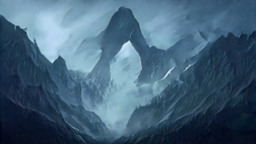

a man standing on top of a snow covered mountain, andreas rocha and john howe, world seen only through a portal, teaser, gigantic mountains, from of thrones, speedpaint, himalayas, 2029, jaw dropping, loadscreen”




Generated 212 prompts and saved to /content/output/desc.csv, enjoy!


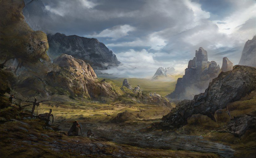

a group of people standing on top of a mountain, d&d trending on artstation, the middle of a valley, mobile wallpaper, cgsociety uhd 4k highly detailed, whiterun in the style of pixar, lonely landscape, square enix cinematic art, in a vast serene landscape, nordic landscape, medieval french landscape, hq 4k phone wallpaper




Generated 324 prompts and saved to /content/output/desc.csv, enjoy!


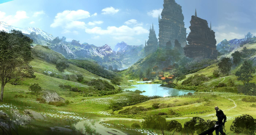

a man riding a horse through a lush green valley, feng zhu concept art, giant medieval tower concept art, mobile wallpaper, lovely valley, inspired by Stephan Martiniere, zenithal view, <mmorpgs scene, beautiful scenic view, anime beautiful peace scene, vertical wallpaper, beautiful render of a fairytale, sunny landscape, large mountains in back, beautiful rendering




Generated 368 prompts and saved to /content/output/desc.csv, enjoy!


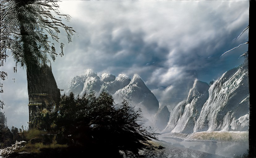

a castle sitting on top of a mountain next to a body of water, by Kim Keever, winter scene fantasy, greek fantasy panorama, stormy snowy fiji mountain, trees and cliffs, by Dan Scott, version 3, beautiful godrays, jagged metal landscape, himalayas, photomanipulation, hildebrandt, 4 0 9 6, misty mood, 3 0




Generated 305 prompts and saved to /content/output/desc.csv, enjoy!
Prompt saved at /content/output/desc.csv


In [ ]:
generate_prompt_csv(csv_path,image_list,prompt_list)

## Analyze image

In [ ]:
def image_analysis(image, clip_model_name):
    # move selected model to GPU and other model to CPU
    if clip_model_name == MODELS[0]:
        ci_vith.clip_model = ci_vith.clip_model.to("cpu")
        ci_vitl.clip_model = ci_vitl.clip_model.to(ci_vitl.device)
        ci = ci_vitl
    else:
        ci_vitl.clip_model = ci_vitl.clip_model.to("cpu")
        ci_vith.clip_model = ci_vith.clip_model.to(ci_vith.device)
        ci = ci_vith

    image = image.convert('RGB')
    image_features = ci.image_to_features(image)

    top_mediums = ci.mediums.rank(image_features, 5)
    top_artists = ci.artists.rank(image_features, 5)
    top_movements = ci.movements.rank(image_features, 5)
    top_trendings = ci.trendings.rank(image_features, 5)
    top_flavors = ci.flavors.rank(image_features, 5)

    medium_ranks = {medium: sim for medium, sim in zip(top_mediums, ci.similarities(image_features, top_mediums))}
    artist_ranks = {artist: sim for artist, sim in zip(top_artists, ci.similarities(image_features, top_artists))}
    movement_ranks = {movement: sim for movement, sim in zip(top_movements, ci.similarities(image_features, top_movements))}
    trending_ranks = {trending: sim for trending, sim in zip(top_trendings, ci.similarities(image_features, top_trendings))}
    flavor_ranks = {flavor: sim for flavor, sim in zip(top_flavors, ci.similarities(image_features, top_flavors))}
    
    return medium_ranks, artist_ranks, movement_ranks, trending_ranks, flavor_ranks

In [ ]:
image_list

['/content/my_images/maxresdefault.jpg',
 '/content/my_images/rockland.jpeg',
 '/content/my_images/55aaa9d7a475c281fcb47e242db7feb9.jpg',
 '/content/my_images/thetree.png']

In [ ]:
medium_list = []
artist_list = []
movement_list = []
trending_list = []
flavour_list = []
image_dict = {}
for idx, images in enumerate(tqdm(image_list, desc='Analyzing images')):
   print(images)
   medium_ranks, artist_ranks, movement_ranks, trending_ranks, flavor_ranks = image_analysis(Image.open(images), MODELS[1])
       
   image_dict[images] = {"medium":medium_ranks,
                                "artist":artist_ranks,
                                "trending":trending_ranks,
                                "flavor":flavor_ranks}

Analyzing images:   0%|          | 0/4 [00:00<?, ?it/s]

/content/my_images/maxresdefault.jpg



100%|██████████| 6/6 [00:00<00:00, 125.03it/s]

Analyzing images:  25%|██▌       | 1/4 [00:00<00:01,  1.96it/s]

/content/my_images/rockland.jpeg



100%|██████████| 6/6 [00:00<00:00, 143.51it/s]

Analyzing images:  50%|█████     | 2/4 [00:01<00:01,  1.98it/s]

/content/my_images/55aaa9d7a475c281fcb47e242db7feb9.jpg



100%|██████████| 6/6 [00:00<00:00, 134.38it/s]

Analyzing images:  75%|███████▌  | 3/4 [00:01<00:00,  1.64it/s]

/content/my_images/thetree.png



100%|██████████| 6/6 [00:00<00:00, 142.15it/s]

Analyzing images: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


In [ ]:
image_dict

{'/content/my_images/maxresdefault.jpg': {'medium': {'a matte painting': 0.289794921875,
   'concept art': 0.281005859375,
   'a detailed matte painting': 0.275390625,
   'a digital painting': 0.2490234375,
   'digital art': 0.2314453125},
  'artist': {'inspired by John Howe': 0.30224609375,
   'inspired by Andreas Rocha': 0.294189453125,
   'inspired by Noah Bradley': 0.29345703125,
   'by Izidor Kršnjavi': 0.2841796875,
   'by Anton Räderscheidt': 0.28173828125},
  'trending': {'deviantart': 0.2406005859375,
   'Artstation': 0.239501953125,
   'Artstation contest winner': 0.2381591796875,
   'trending on deviantart': 0.232177734375,
   'deviantart contest winner': 0.224853515625},
  'flavor': {'icy mountains': 0.334228515625,
   'dota! matte painting concept art': 0.322021484375,
   'dota matte painting concept art': 0.3212890625,
   "theme :'icewind dale '": 0.31884765625,
   'lord of the rings concept art': 0.315185546875}},
 '/content/my_images/rockland.jpeg': {'medium': {'a matte

In [ ]:
import pandas as pd
analyze = pd.DataFrame(image_dict).T.reset_index().rename(columns={'index':'Image_path'})

In [ ]:
analyze.to_csv('/content/output/analyze.csv')

## Download images

In [ ]:
!wget "https://i.ytimg.com/vi/z3lsZcV76KE/maxresdefault.jpg"

--2023-03-19 04:42:16--  https://i.ytimg.com/vi/z3lsZcV76KE/maxresdefault.jpg
Resolving i.ytimg.com (i.ytimg.com)... 64.233.183.119, 173.194.193.119, 173.194.194.119, ...
Connecting to i.ytimg.com (i.ytimg.com)|64.233.183.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81044 (79K) [image/jpeg]
Saving to: ‘maxresdefault.jpg’

maxresdefault.jpg   100%[===================>]  79.14K  --.-KB/s    in 0.001s  

2023-03-19 04:42:16 (98.8 MB/s) - ‘maxresdefault.jpg’ saved [81044/81044]



In [ ]:
!wget "https://tomco.neocities.org/thetree.png"

--2023-03-19 05:15:42--  https://tomco.neocities.org/thetree.png
Resolving tomco.neocities.org (tomco.neocities.org)... 198.51.233.2, 2620:2:6000::a:1
Connecting to tomco.neocities.org (tomco.neocities.org)|198.51.233.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131618 (129K) [image/png]
Saving to: ‘thetree.png’

thetree.png         100%[===================>] 128.53K  --.-KB/s    in 0.09s   

2023-03-19 05:15:42 (1.40 MB/s) - ‘thetree.png’ saved [131618/131618]



In [ ]:
!wget "https://tomco.neocities.org/rockland.jpeg"

--2023-03-19 05:16:45--  https://tomco.neocities.org/rockland.jpeg
Resolving tomco.neocities.org (tomco.neocities.org)... 198.51.233.2, 2620:2:6000::a:1
Connecting to tomco.neocities.org (tomco.neocities.org)|198.51.233.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85722 (84K) [image/jpeg]
Saving to: ‘rockland.jpeg’

rockland.jpeg       100%[===================>]  83.71K  --.-KB/s    in 0.04s   

2023-03-19 05:16:45 (1.86 MB/s) - ‘rockland.jpeg’ saved [85722/85722]



In [ ]:
! wget "https://i.pinimg.com/originals/55/aa/a9/55aaa9d7a475c281fcb47e242db7feb9.jpg"

--2023-03-19 05:38:18--  https://i.pinimg.com/originals/55/aa/a9/55aaa9d7a475c281fcb47e242db7feb9.jpg
Resolving i.pinimg.com (i.pinimg.com)... 23.220.144.143, 23.220.144.133, 2a04:4e42:84::84
Connecting to i.pinimg.com (i.pinimg.com)|23.220.144.143|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 206978 (202K) [image/jpeg]
Saving to: ‘55aaa9d7a475c281fcb47e242db7feb9.jpg’

55aaa9d7a475c281fcb 100%[===================>] 202.13K  --.-KB/s    in 0.04s   

2023-03-19 05:38:19 (5.40 MB/s) - ‘55aaa9d7a475c281fcb47e242db7feb9.jpg’ saved [206978/206978]



In [ ]:
!wget "https://pharmapsychotic.com/images/robo_owl.jpg"

--2023-03-19 07:32:30--  https://pharmapsychotic.com/images/robo_owl.jpg
Resolving pharmapsychotic.com (pharmapsychotic.com)... 69.163.152.182
Connecting to pharmapsychotic.com (pharmapsychotic.com)|69.163.152.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137100 (134K) [image/jpeg]
Saving to: ‘robo_owl.jpg’

robo_owl.jpg        100%[===================>] 133.89K  --.-KB/s    in 0.1s    

2023-03-19 07:32:30 (983 KB/s) - ‘robo_owl.jpg’ saved [137100/137100]



In [ ]:
os.mkdir('my_images')

In [ ]:
import os
import shutil 
shutil.copy("/content/55aaa9d7a475c281fcb47e242db7feb9.jpg","/content/my_images")

'/content/my_images/55aaa9d7a475c281fcb47e242db7feb9.jpg'